In [1]:
import os
from glob import glob
import json
import numpy as np
import pandas as pd
# from sklearn.manifold import TSNE
from openTSNE import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt


## Setting

In [2]:
data_dir = r"/media/yiting/NewVolume/Data/Videos"
analysis_dir = r"/media/yiting/NewVolume/Analysis"
session_name = "2025-08-22"
ap_dir = os.path.join(analysis_dir, session_name, "anipose")
angle_dir = os.path.join(ap_dir,"angles")
angle_trials = sorted(glob(os.path.join(angle_dir, "*.csv")))
log_dir = os.path.join(data_dir, session_name, "trial_logs")
log_trials = sorted(glob(os.path.join(log_dir, "*.json")))
frame_number = 300

save_dir = os.path.join(analysis_dir,"hand_config")
os.makedirs(save_dir, exist_ok = True)


## Data extraction

In [3]:
# Create a table
# 1. Extract angles from the holding time
# 2. Add trial name and shape id
df = pd.DataFrame()
for log_trial,angle_trial in zip(log_trials, angle_trials):
    
    angle_df = pd.read_csv(os.path.join(angle_dir, angle_trial))
    # Open and read the JSON file
    with open(os.path.join(log_dir, log_trial), 'r') as file:
        json_data = json.load(file)

    new_df = angle_df.loc[[frame_number]]
    new_df["trial_name"] = log_trial[11:19]
    new_df["shape_id"] = json_data["shape_id"]
    new_df["correct"] = json_data["has_played_success_tone"]
    new_df["is_holdshort"] = json_data["object_released"]
    new_df["is_holdlong"] = json_data["object_held"]
    new_df["is_sameShape"] = json_data["reward_direction"] == 'holdshort'

    df = pd.concat([df,new_df])
    
df.reset_index(drop=True, inplace=True)


## t-SNE 

In [ ]:
## t-SNE 
# Prepare data for t-SNE
# Filter trials
# df_filtered = df.dropna().query('correct == True and is_holdlong == True').copy()
# df_filtered = df.dropna().query('correct == True and is_holdshort == True').copy()
df_filtered = df.dropna().query('correct == True').copy()
# df_filtered = df.dropna().copy()

# Rank by shape_id, sort, reset
df_sorted = (
    df_filtered.assign(rank=df_filtered['shape_id'].str.lower().rank(method='dense'))
              .sort_values('rank')
              .drop(columns='rank')
              .reset_index(drop=True)
)

# Extract shape_type and orientation
df_sorted['shape_type'] = df_sorted['shape_id'].apply(lambda x: x.split('_')[0])
df_sorted['orientation'] = df_sorted['shape_id'].apply(lambda x: x.split('_')[1])

# Prepare features for t-SNE
df_features = df_sorted.iloc[:, 0:15]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Compute t-SNE
tsne = TSNE(n_components=2, random_state=42,
            learning_rate='auto', init='random', perplexity=8)
tsne_features = tsne.fit_transform(X_scaled)

# Attach t-SNE coords to df_scaled
df_sorted['tsne-d1'] = tsne_features[:, 0]
df_sorted['tsne-d2'] = tsne_features[:, 1]

## Visualization

In [ ]:
# -----------------------------------------
# Plot: color by shape_type, marker by orientation
# -----------------------------------------
fig, ax = plt.subplots(figsize=(10, 8))

# ---- Color mapping (shape_type) ----
shape_types = df_sorted['shape_type'].unique()
cmap = cm.get_cmap('Spectral', len(shape_types))
color_map = {st: cmap(i) for i, st in enumerate(shape_types)}

# ---- Marker mapping (orientation) ----
marker_map = {
    "0": "o",      # circle
    "2": "D",      # diamond
    "02": "*",     # star
}
df_sorted['marker'] = df_sorted['orientation'].astype(str).map(marker_map)

# # ---- Edge mapping (correct vs error) ----
# edge_map = {
#     True: 'none',
#     False: 'black'
# }
# df_sorted['edgecolor'] = df_sorted['correct'].map(edge_map)

# ---- Edge mapping (long vs short) ----
edge_map = {
    True: 'none',
    False: 'black'
}
df_sorted['edgecolor'] = df_sorted['correct'].map(edge_map)

# ---- Plot grouped by color + marker + edge ----
for st in shape_types:
    sub = df_sorted[df_sorted['shape_type'] == st]
    for m in sub['marker'].unique():
        tmp = sub[sub['marker'] == m]
        ax.scatter(
            tmp['tsne-d1'], tmp['tsne-d2'],
            color=color_map[st],
            marker=m,
            s=30,
            edgecolors=tmp['edgecolor'],
            label=f"{st}, {m}"
        )

# ---- Labels ----
ax.set_title(session_name + '_all')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
plt.tight_layout()

# ---- Three separate legends ----
# 1. Legend for shape_type (colors)
color_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color_map[st], markersize=8,
               label=str(st))
    for st in shape_types
]

# 2. Legend for orientation (markers)
marker_handles = [
    plt.Line2D([0], [0], marker=m, color='k', linestyle='',
               markersize=8, label=ori)
    for ori, m in marker_map.items()
]
# 3. Legend for correct vs error or hold long vs hold short (edgecolors)
edge_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor='gray', markeredgecolor=ec, markersize=8,
               label='error' if ec == 'black' else 'correct')
    for ec in edge_map.values()
]

leg1 = ax.legend(handles=color_handles, title='shape_type',
                 loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=8)
ax.add_artist(leg1)

leg2 = ax.legend(handles=marker_handles, title='orientation',
          loc='upper center', bbox_to_anchor=(0.2, -0.075), ncol=5)
ax.add_artist(leg2)

ax.legend(handles=edge_handles, title='trial outcome',
          loc='upper center', bbox_to_anchor=(0.8, -0.075), ncol=2)

# Save the figure
plt.savefig(os.path.join(save_dir, session_name + "_hand_config_all_f300_tsne_perplexity_8.png"), dpi=300, bbox_inches='tight')
plt.show()


## Clustering analysis

In [ ]:
# TSNE clustering analysis
from sklearn.cluster import KMeans
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_sorted['cluster'] = kmeans.fit_predict(tsne_features)

## Save results (optional)

In [ ]:
df_sorted.to_csv(os.path.join(save_dir, session_name + "_hand_config_correct_long_f300_tsne_perplexity_8_clusters.csv"), index=False)

## Feature contribution

In [ ]:
# Train a Surrogate Model (Random Forest)
# We use the original features (X) to predict the t-SNE coordinates (y)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, tsne_features)

# 4. Extract Feature Importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort descending

# Create a readable DataFrame of results
feature_importance_df = pd.DataFrame({
    'Feature': df_features.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 5. Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Features Driving the t-SNE Structure')
plt.xlabel('Relative Importance Score')
plt.ylabel('Original Feature Name')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, session_name + "_feature_importance_correct_long.png"), dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 5 Most Influential Features:")
print(feature_importance_df.head(5))

In [ ]:
import shap

X_df = pd.DataFrame(X_scaled, columns=df_features.columns)
rf.fit(X_df, tsne_features)
# 1. Initialize the explainer with your trained surrogate model
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_df)


# shap_values is a list of length 2.
# shap_values[0] -> Explains movement along the X-axis (Dimension 1)
# shap_values[1] -> Explains movement along the Y-axis (Dimension 2)

# 2. Plotting Dimension 1 (X-axis) drivers
plt.title("What drives separation along the Horizontal Axis (Dim 1)?")
shap.summary_plot(shap_values[0], X_df, show=False)
plt.savefig(os.path.join(save_dir, session_name + "_feature_importance_d1_correct_long.png"), dpi=300, bbox_inches='tight')

plt.show()

# 3. Plotting Dimension 2 (Y-axis) drivers
plt.title("What drives separation along the Vertical Axis (Dim 2)?")
shap.summary_plot(shap_values[1], X_df, show=False)
plt.savefig(os.path.join(save_dir, session_name + "_feature_importance_d2_correct_long.png"), dpi=300, bbox_inches='tight')
plt.show()

## Error trials

In [ ]:
# Train openTSNE with all correct trials and get embeddings of error trials
# openTSNE implements a parametric “embedding of new points into an existing t-SNE map”.

# Prepare data for t-SNE
# Filter trials
df_correct = df.dropna().query('correct == True').copy()
df_errors = df.dropna().query('correct == False').copy()

# Rank by shape_id, sort, reset
df_correct_sorted = (
    df_correct.assign(rank=df_correct['shape_id'].str.lower().rank(method='dense'))
              .sort_values('rank')
              .drop(columns='rank')
              .reset_index(drop=True)
)

df_errors_sorted = (
    df_errors.assign(rank=df_errors['shape_id'].str.lower().rank(method='dense'))
              .sort_values('rank')
              .drop(columns='rank')
              .reset_index(drop=True)
)

# Extract shape_type and orientation
df_correct_sorted['shape_type'] = df_correct_sorted['shape_id'].apply(lambda x: x.split('_')[0])
df_correct_sorted['orientation'] = df_correct_sorted['shape_id'].apply(lambda x: x.split('_')[1])
df_errors_sorted['shape_type'] = df_errors_sorted['shape_id'].apply(lambda x: x.split('_')[0])
df_errors_sorted['orientation'] = df_errors_sorted['shape_id'].apply(lambda x: x.split('_')[1])

# Prepare features for t-SNE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_correct_sorted.iloc[:, 0:15])
X_test_scaled = scaler.transform(df_errors_sorted.iloc[:, 0:15])
# Compute open t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=8,
    initialization="pca",
)
X_train_emb = tsne.fit(X_train_scaled)
X_test_emb = X_train_emb.transform(X_test_scaled)

# Attach t-SNE coords to df_scaled
df_correct_sorted['tsne-d1'] = X_train_emb[:, 0]
df_correct_sorted['tsne-d2'] = X_train_emb[:, 1]

df_errors_sorted['tsne-d1'] = X_test_emb[:, 0]
df_errors_sorted['tsne-d2'] = X_test_emb[:, 1]

df_sorted = pd.concat([df_correct_sorted, df_errors_sorted]).reset_index(drop=True)

In [ ]:
# -----------------------------------------
# Plot: color by shape_type, marker by orientation
# -----------------------------------------
fig, ax = plt.subplots(figsize=(10,10))

# ---- Color mapping (shape_type) ----
shape_types = df_sorted['shape_type'].unique()
# Get the colormap
cmap = plt.get_cmap('Spectral')
# Sample evenly spaced colors from 0 to 1
color_map = {st: cmap(i / (len(shape_types) - 1)) for i, st in enumerate(shape_types)}

# ---- Marker mapping (orientation) ----
marker_map = {
    "0": "o",      # circle
    "2": "D",      # diamond
    "02": "*",     # star
}
df_sorted['marker'] = df_sorted['orientation'].astype(str).map(marker_map)

# ---- Edge mapping (correct vs error) ----
edge_map = {
    True: 'none',
    False: 'black'
}
df_sorted['edgecolor'] = df_sorted['correct'].map(edge_map)

# # ---- Edge mapping (long vs short) ----
# edge_map = {
#     True: 'none',
#     False: 'black'
# }
# df_sorted['edgecolor'] = df_sorted['correct'].map(edge_map)

# ---- Plot grouped by color + marker + edge ----
for st in shape_types:
    sub = df_sorted[df_sorted['shape_type'] == st]
    for m in sub['marker'].unique():
        tmp = sub[sub['marker'] == m]
        ax.scatter(
            tmp['tsne-d1'], tmp['tsne-d2'],
            facecolor=color_map[st],
            marker=m,
            s=30,
            edgecolors=tmp['edgecolor'],
            label=f"{st}, {m}"
        )

# ---- Labels ----
ax.set_title(session_name + '_correct_vs_error')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
plt.tight_layout()

# ---- Three separate legends ----
# 1. Legend for shape_type (colors)
color_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color_map[st], markersize=8,
               label=str(st))
    for st in shape_types
]

# 2. Legend for orientation (markers)
marker_handles = [
    plt.Line2D([0], [0], marker=m, color='k', linestyle='',
               markersize=8, label=ori)
    for ori, m in marker_map.items()
]
# 3. Legend for correct vs error or hold long vs hold short (edgecolors)
edge_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor='gray', markeredgecolor=ec, markersize=8,
               label='error' if ec == 'black' else 'correct')
    for ec in edge_map.values()
]

leg1 = ax.legend(handles=color_handles, title='shape_type',
                 loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=8)
ax.add_artist(leg1)

leg2 = ax.legend(handles=marker_handles, title='orientation',
          loc='upper center', bbox_to_anchor=(0.2, -0.075), ncol=5)
ax.add_artist(leg2)

ax.legend(handles=edge_handles, title='trial outcome',
          loc='upper center', bbox_to_anchor=(0.8, -0.075), ncol=2)

# Save the figure
plt.savefig(os.path.join(save_dir, session_name + "_hand_config_correct_error_f300_opentsne_perplexity_8.png"), dpi=300, bbox_inches='tight')
plt.show()


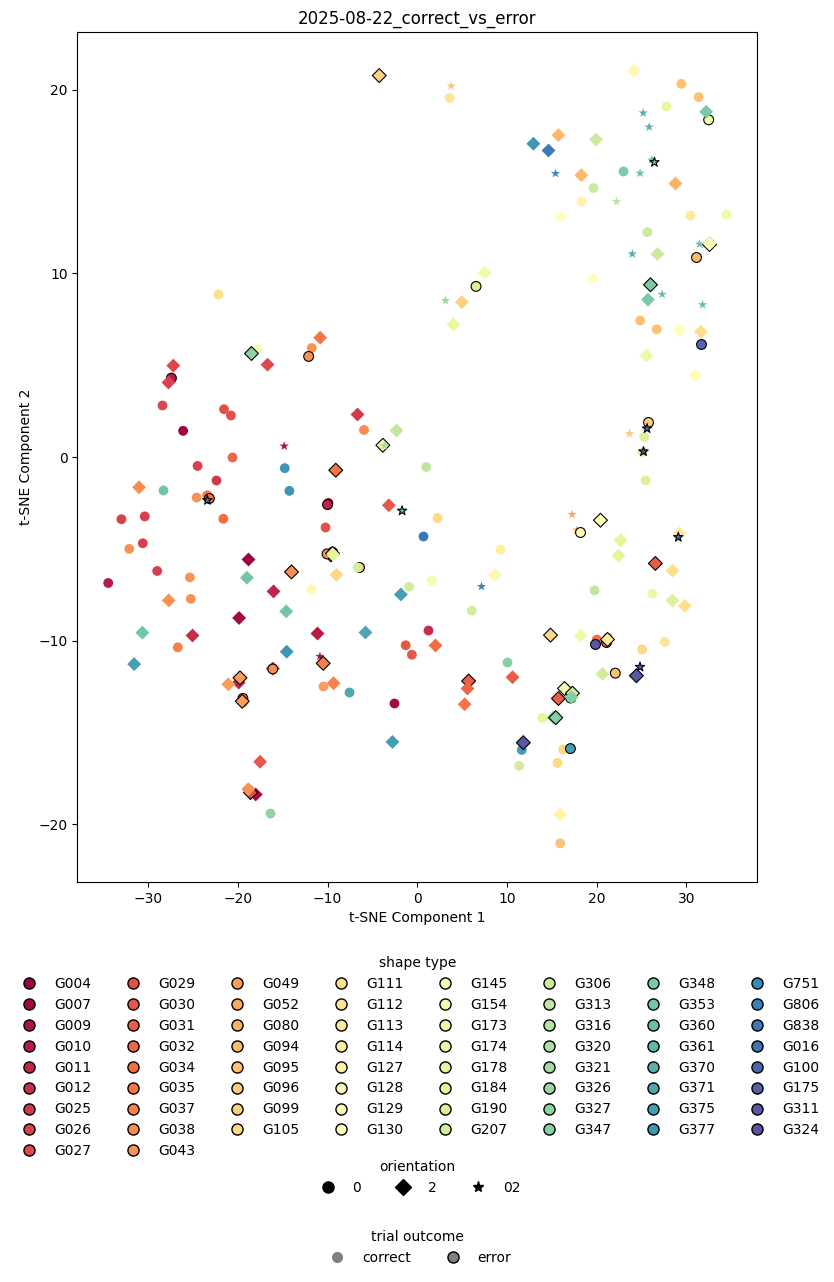

In [17]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import os

fig = plt.figure(figsize=(8, 10))

# --- Main t-SNE axis ---
ax = fig.add_axes([0.1, 0.4, 0.85, 0.85])   # leave space at bottom

# ---- Color mapping (shape_type) ----
shape_types = df_sorted['shape_type'].unique()
cmap = plt.get_cmap('Spectral')
color_map = {st: cmap(i / max(len(shape_types)-1, 1)) for i, st in enumerate(shape_types)}

# ---- Marker mapping ----
marker_map = {"0": "o", "2": "D", "02": "*"}
df_sorted['marker'] = df_sorted['orientation'].astype(str).map(marker_map)

# ---- Edge mapping ----
edge_map = {True: 'none', False: 'black'}
df_sorted['edgecolor'] = df_sorted['correct'].map(edge_map)

# ---- Scatter plot ----
for st in shape_types:
    sub = df_sorted[df_sorted['shape_type'] == st]
    for m in sub['marker'].unique():
        tmp = sub[sub['marker'] == m]
        ax.scatter(
            tmp['tsne-d1'], tmp['tsne-d2'],
            facecolors=color_map[st],
            marker=m,
            s=50,
            edgecolors=tmp['edgecolor'],
            linewidths=0.8
        )

# ---- Labels ----
ax.set_title(session_name + '_correct_vs_error')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')

# -------------------------------------------------------------
# Build legend handles
# -------------------------------------------------------------
color_handles = [
    mlines.Line2D([], [], marker='o', linestyle='',
                  markerfacecolor=color_map[st], markeredgecolor='k',
                  markersize=8, label=str(st))
    for st in shape_types
]

marker_handles = [
    mlines.Line2D([], [], marker=m, linestyle='',
                  color='k', markersize=8, label=ori)
    for ori, m in marker_map.items()
]

edge_handles = [
    mlines.Line2D([], [], marker='o', linestyle='',
                  markerfacecolor='gray', markeredgecolor=ec,
                  markersize=8, label='error' if ec == 'black' else 'correct')
    for ec in edge_map.values()
]

# -------------------------------------------------------------
# Automatic legend stacking 
# -------------------------------------------------------------

ax_leg1 = fig.add_axes([0.1, 0.2, 0.85, 0.05]); ax_leg1.axis("off")
ax_leg2 = fig.add_axes([0.1, 0.08, 0.85, 0.05]); ax_leg2.axis("off")
ax_leg3 = fig.add_axes([0.1, 0.01, 0.85, 0.05]); ax_leg3.axis("off")

ax_leg1.legend(color_handles,  [h.get_label() for h in color_handles],  ncol=8, loc="center", frameon=False, title="shape type")
ax_leg2.legend(marker_handles, [h.get_label() for h in marker_handles], ncol=8, loc="center", frameon=False, title="orientation")
ax_leg3.legend(edge_handles,   [h.get_label() for h in edge_handles],   ncol=8, loc="center", frameon=False, title="trial outcome")

plt.savefig(
    os.path.join(save_dir, session_name + "_hand_config_correct_error_auto_legends.png"),
    dpi=300, bbox_inches='tight'
)
plt.show()
